In [183]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [184]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse
import metrics

In [185]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [186]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [187]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [188]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_simple_example_1_prefilter5.pt", map_location=device)

In [189]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [190]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.43M


In [191]:
import pickle as pkl

with open('../data/control/test_set_simple_example_1.pkl', 'rb') as f:
    test_set = pkl.load(f)

data_test = test_set['data_test']
from control.matlab import *

In [192]:
ts = 1e-2
T = 20#seq_len*ts
t_CL = np.arange(0, T, ts)
r_batch = np.zeros((batch_size, len(t_CL)))
# Generate the reference
generate_from_model = False
if generate_from_model:
    test_ds = SimpleExample1Dataset(seq_len=len(t_CL), normalize=True, return_y=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    batch_u, batch_e, batch_y, batch_r = next(iter(test_dl))
    for i in range(r_batch.shape[0]):
        # get virtual error
        r_batch[i,:] = batch_r[i,:,0]
else:
    r = np.zeros(t_CL.shape)
    r[t_CL < 10] = 10
    r[(t_CL >= 2.5) & (t_CL < 5)] = -10
    r[(t_CL >= 5.0) & (t_CL < 7.5)] = 0
    r[(t_CL >= 7.5) & (t_CL < 10)] = 5
    r[(t_CL >= 10.) & (t_CL < 12.5)] = -5
    r[(t_CL >= 12.5) & (t_CL < 15.)] = 20
    r[(t_CL >= 15.0) & (t_CL < 17.5)] = 0
    r[(t_CL >= 17.5) & (t_CL < 20.0)] = -20
    for i in range(r_batch.shape[0]):
        # get virtual error
        r_batch[i,:] = r

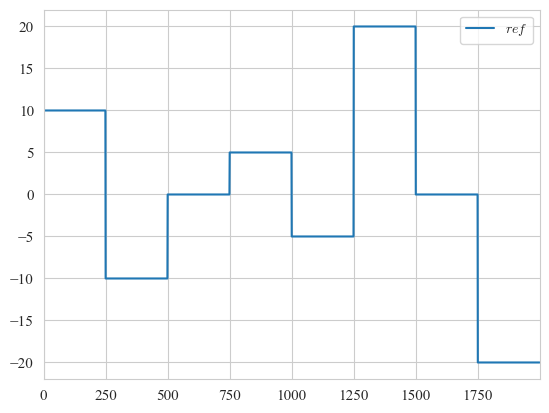

In [193]:
plt.plot(r_batch[0,:])
plt.legend(['$ref$'])

In [194]:
n_testing = 50
H = 5

y_log = np.zeros((n_testing,len(t_CL)))
e_log = np.zeros((n_testing,len(t_CL)))
u_log = np.zeros((n_testing,len(t_CL)))

Ts = 1e-2; Fs = 1 / Ts
s = tf('s')
# problem data

with torch.no_grad():
    for n_testing in range(n_testing):#len(data_test)):
        
        print(n_testing)
        data = data_test[n_testing]
        
        # system
        num = [data['num_1']]
        den = [data['den_1'], data['den_2'], data['den_3']]
        P = tf(num, den)
        
        
        e = torch.Tensor([[[]]])
        u = torch.Tensor([[[]]])
        
        # This is like t=0, for our model we need u(-1).
        u_i = 1e-6 # u(-1)
        x_i = np.array([[1e-6, 1e-6]])
        y_i = 1e-6
        
        u_log[n_testing,0] = u_i
        y_log[n_testing,0] = y_i
        
        for i in range(0,len(t_CL)):#batch_u.shape[0]): # for each system
            
            u_i = torch.Tensor([[[u_i]]])   # first you add u(t)
            u = torch.cat((u,u_i / 1000),2)
            
            e_i = torch.Tensor([[[r_batch[n_testing,i] - y_i]]]) # e(t)
            e = torch.cat((e,e_i / 0.3),2)
            
            if i < H:
                pred, _ = model(e.reshape(1,-1,1), u.reshape(1,-1,1))
            else:
                e_tmp = e.reshape(1,-1,1)
                u_tmp = u.reshape(1,-1,1)
                pred, _ = model(e_tmp[:,-H:,:], u_tmp[:,-H:,:])
            
            u_i = pred[:,-1,:].item() * 1000 # u(t)
            
            # Controller u(t) = C(e(t-1),u(t-1))
            
            y_i, _, x_i = lsim(P, u_i, np.array([0.0, Ts]), x_i[-1], return_x = True)
            y_i = y_i[-1]  # y(t) <- y(t+1)
            
        
            e_log[n_testing,i] = e_i
            
            if (i+1) < len(t_CL) :
              u_log[n_testing,i+1] = u_i
              y_log[n_testing,i+1] = y_i

0


/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1003: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1009: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


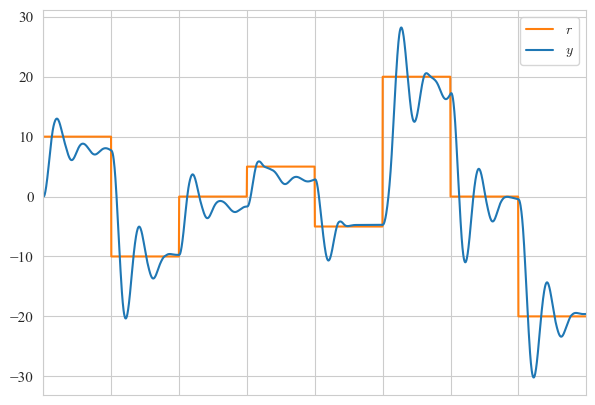

In [195]:
fig = plt.figure(figsize=(7, 5))
#plt.plot(t_CL, r)
plt.plot(t_CL, r_batch[0,:], label="$r$", c='tab:orange')
plt.plot(t_CL, y_log[0,:].T, label="$y$", c='tab:blue', alpha=1)
plt.legend(['$r$','$y$'])
plt.tick_params('x', labelbottom=False)

In [196]:
## CALCULATE MSE (r, y) 
error_tot = 0

for i in range(n_testing+1):
     for k in range(len(e_log[i])):
        squared_error = e_log[i,k] * e_log[i,k]
        error_tot += squared_error
         
MSE = error_tot / (len(e_log[0]) * (n_testing+1))
print(f"MSE: {MSE:.5f}")


# relative error, in percentage
relative_error = 0

for i in range(n_testing+1) : 
    for k in range(len(e_log[i])):
        e_abs = np.abs(e_log[i,k])
        ref_abs = (np.abs(r_batch[i,k]))
        e_rel = e_abs / ref_abs
        if e_rel < 20 : # samples that are too big are caused by divisions by zero, unwanted
            relative_error += e_rel
        


re = relative_error/ ( len(e_log[0]) * (n_testing+1)) * 100

print(f"Relative Error: {re:.2f}%")

MSE: 28.67858


/tmp/ipykernel_57374/2251602270.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  e_rel = e_abs / ref_abs


Relative Error: 23.58%


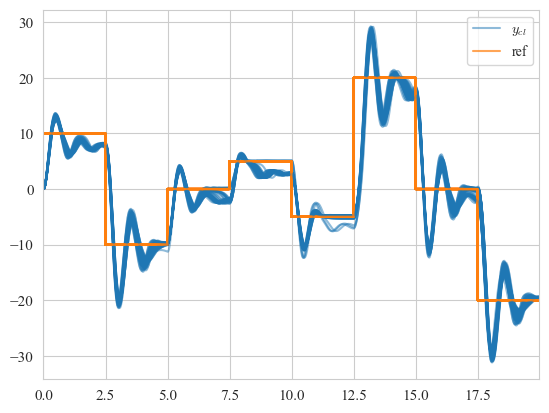

In [197]:
 for i in range(0,n_testing):
    
        plt.plot(t_CL,  y_log[i], c='tab:blue', alpha=0.5)
        plt.plot(t_CL, r_batch[i], label='ref',c='tab:orange', alpha = 0.7)
        plt.legend(['$y_{cl}$','ref'])
plt.show()